# Proyecto 1 - Etapa 1

 Estudiante 1: María Alejandra Pinzón Roncancio - 202213956

 Estudiante 2: Ignacio Chaparro - 202220577

Estudiante 3: Mateo Lopez - 202220119

## Sección 1: Canvas

## Sección 2: Entendimiento y preparación de los datos

### 2.1 Descripción del entendimiento de los datos:
Primero, vamos a describir las variables que se tienen en el dataset, para poder entender la información que se tiene y poder utilizarla para el modelado.
- **`ID`**: Identificador único de cada noticia, no tiene ninguna relevancia para el objetivo de clasificación buscado, así que no será de importancia como variable para la etapa de modelado.
- **`Label`**: Categoría objetivo. Como los datos de prueba son supervisados, se tiene una categoría donde se especifica cada noticia como veraaz (1) o falsa (0).
- **`Titulo`**: Título de la noticia.
- **`Descripción`**: Breve resumen de la noticia mencionada.
- **`Fecha`**: Fecha en la que se publicó la noticia

### 2.2 Limpieza preliminar de datos:


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Analizando la estructura del archivo de datos de entrenamiento, se evidencia que hay algunas filas que tienen saltos de línea innecesarios, los cuales dificultan el almacenamiento de los datos en estructuras (como los dataFrames de Pandas). Debido a esto, se decidió primero crear un nuevo archivo donde se eliminan los saltos de página innecesarios y se transforman los datos a una forma estructurada.

In [2]:
original = "fake_news_spanish.csv"
limpio = "fake_news_spanish_limpio.csv"

with open(original, "r", encoding="utf-8") as infile, open(limpio, "w", encoding="utf-8", newline="") as outfile:
    reader = csv.reader(infile, delimiter=";")
    writer = csv.writer(outfile, delimiter=",")  

    categorias = next(reader)
    writer.writerow(categorias)

    for row in reader:
        '''Quitar cada salto de línea y poner un espacio, también se quita cada punto y
        coma (;) que no sea separador entre las categorías'''
        cleaned_row = [field.replace("\n", " ").replace(";", ",") for field in row]
        writer.writerow(cleaned_row)

### 2.2.1 Carga de datos de entrenamiento

In [3]:
data_path = "fake_news_spanish_limpio.csv"
dataframe_train = pd.read_csv(data_path)

In [4]:
dataframe_train.head()


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


In [5]:
dataframe_train.describe

<bound method NDFrame.describe of        ID  Label                                             Titulo  \
0      ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1      ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2      ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3      ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4      ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   
...    ..    ...                                                ...   
57058  ID      1  El Defensor del Pueblo reclama a la Comunidad ...   
57059  ID      0  El EQUO plantea ceder la presidencia de la Com...   
57060  ID      1  Alberto Garzón: 'Que los Borbones son unos lad...   
57061  ID      1  Vox exige entrar en el Gobierno de Castilla y ...   
57062  ID      1  Unas 300 personas protestan contra la visita d...   

                                             Descripcion       Fecha  
0      El diario británico publicó este pa

Se revisará si hay un desbalanceo de clases con la variable objetivo, es decir, revisar si en los datos de entrenamiento es equitativo el número de artículos falsos (0) con el número de articulos verídicos (1):

In [6]:
print(pd.value_counts(dataframe_train['Label']))

Label
1    33158
0    23905
Name: count, dtype: int64


C:\Users\57304\AppData\Local\Temp\ipykernel_26748\1949579262.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(dataframe_train['Label']))


Se puede evidenciar que en los 57,063 artículos de los datos de entrenamiento, se tiene un desbalanceo ligero, ya que el alrededor de 58.1% de los artículos son verídicos (1), y alrededor del 41.89% de los artículos son falsos (0).

Antes de tokenizar y normalizar los datos, se revisarán si hay elementos de datos nulos:

In [7]:
dataframe_train.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Dado que hay 16 filas con el Título nulo, se van a reemplazar por espacios en blanco para que no haya problema con la tokenización posteriormente:

In [8]:
dataframe_train['Titulo'] = dataframe_train['Titulo'].fillna('').astype(str)

Ahora se revisará de nuevo la cantidad de elementos nulos:

In [9]:
dataframe_train.isnull().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

In [10]:
print(dataframe_train.shape)
print(dataframe_train.dtypes)

(57063, 5)
ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object


Función auxiliar para instalar stanza en caso de que no sirva por la terminal

In [11]:
import nltk
import re
from nltk.stem import PorterStemmer
from unidecode import unidecode
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('spanish')
ps = PorterStemmer()
stop_words = set(stopwords)
wpt = nltk.WordPunctTokenizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57304\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Para realizar la preparación y limpieza de los datos se realizarán las siguientes transformaciones de limpieza de datos, que serán utilizadas cuando ya se tenga la lista tokenizada de cada titulo y descripción:
- Eliminar caracteres que no estén en formato ASCII
- Conversión de todo el texto a minúsculas
- Eliminación de stopwords
- Eliminación de acentuaciones y signos de puntuación
- Lematización de verbos

In [12]:
def normalize_documents(doc):
  #Eliminar acentos
  #doc = unidecode(doc)
  #Eliminar signos de puntuación y valores numéricos
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]','',doc, re.I|re.A)
  #Estandarizar todo el texto en minúsculas
  doc = doc.lower()
  #Eliminar espacios en blanco
  doc = doc.strip()
  tokens = wpt.tokenize(doc)
  filtered_token = [ps.stem(token) for token in tokens if token not in stopwords]
  doc = ' '.join(filtered_token)
  return doc


In [13]:
dataframe_train['titulo_normalizado'] = dataframe_train['Titulo'].apply(normalize_documents)

In [14]:
dataframe_train['titulo_normalizado']

0        the guardian va sánchez europa necesita apuest...
1        revelan gobierno negocio liberación mirel camb...
2        ahora nunca joan fuster estatuto valenciano cu...
3        iglesia alienta yolanda díaz erc eh bildu nego...
4          puigdemont ninguna tragedia repetición eleccion
                               ...                        
57058    defensor pueblo reclama comunidad madrid dato ...
57059    equo plantea ceder presidencia comunidad madri...
57060    alberto garzón borbon ladron hecho históricame...
57061    vox exig entrar gobierno castilla león cara vi...
57062           una persona protestan visita rey barcelona
Name: titulo_normalizado, Length: 57063, dtype: object

In [15]:
dataframe_train['desc_normalizado'] = dataframe_train['Descripcion'].apply(normalize_documents)

In [16]:
dataframe_train['desc_normalizado']

0        diario británico publicó pasado juev editori p...
1        revelan gobierno negocio liberación mirel camb...
2        valencianismo convoca castelló fiesta grand co...
3        política igual negociar empresario negociar gr...
4        entrevista punt avui líder jxcat desdramatizad...
                               ...                        
57058    gobierno region indicado atención día incluyen...
57059    si higien democrática lleva exigencia tener pa...
57060    coordinador feder iu asegura monarquía putrefacta
57061    santiago abasc vox derecho deber formar gobier...
57062    mosso desquadra blindado alrededor estación fr...
Name: desc_normalizado, Length: 57063, dtype: object

Ahora, para poder usar los modelos de la librería de Scikit Learn, es necesario convertir las columnas que queremos utilizar ('desc_normalizado' y 'titulo_normalizado') en representaciones numéricas de los tokens. Para esto, decidimos utilizar la representación TF-iDF:

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000) 
titulo_tfidf = tfidf.fit_transform(dataframe_train['titulo_normalizado'])
desc_tfidf = tfidf.fit_transform(dataframe_train['desc_normalizado'])

In [18]:
#Se apilan en una variable las matrices TF-IDF de titulo y descripciones
import scipy.sparse as sp
X_tfidf = sp.hstack([titulo_tfidf, desc_tfidf])

In [19]:
feature_names = np.array(tfidf.get_feature_names_out().tolist() * 2)

## Modelado y evaluación

In [20]:
# Se selecciona la variable objetivo, en este caso "Label".
label=dataframe_train['Label']


Para realizar el modelo con los datos ya normalizados y estandarizados, se tomará el 80% de los datos para entrenar el modelo, y el 20% será para hacer pruebas con el modelo una vez haya sido creado.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf,
                                                     label,
                                                     test_size=0.2,
                                                     random_state=0)

## Primer modelo: Random Forest Classifier

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train, Y_train)


RandomForestClassifier(random_state=0)

### Predicción del 20% de prueba con el modelo de Random Forest Classifier

In [31]:
Y_pred = rf_classifier.predict(X_test)
presicion = accuracy_score(Y_test, Y_pred)
print(f"Exactitud: {presicion:.2f}")

Exactitud: 0.89


In [24]:
print("Reporte para Random Forest Classifier:")
print(classification_report(Y_test, Y_pred))



Reporte para Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      4677
           1       0.88      0.94      0.91      6736

    accuracy                           0.89     11413
   macro avg       0.90      0.88      0.89     11413
weighted avg       0.89      0.89      0.89     11413



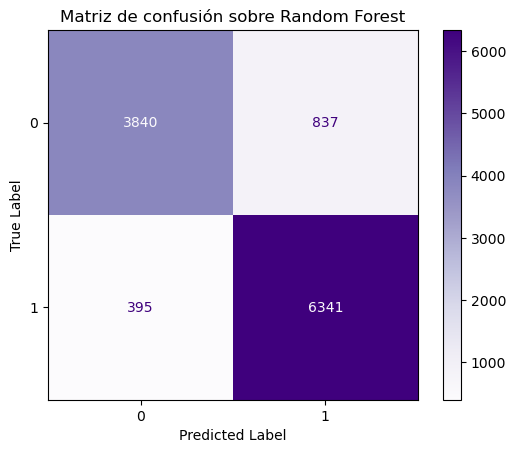

In [25]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot(cmap="Purples")
plt.title("Matriz de confusión sobre Random Forest")
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 
plt.show()

In [28]:
importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'word': feature_names, 'importance': importances})
top_words = feature_importance_df.sort_values(by="importance", ascending=False)
print("Top palabras con mayor peso para Random forest")
print(top_words.head(20)) 


Top palabras con mayor peso para Random forest
            word  importance
1320        equo    0.032742
329      espanol    0.030048
304   emergencia    0.022704
144         cita    0.020905
122       carcel    0.020382
627        niega    0.020374
1689         per    0.020303
1288      eajpnv    0.016662
1101         bng    0.016547
969        vasco    0.014638
857      segunda    0.013891
228        debat    0.013350
475    investiga    0.012685
1116     canaria    0.012258
694       person    0.012226
1971         ver    0.011832
1711      podemo    0.010808
716     polemica    0.008940
557         mart    0.008676
1134   catalunya    0.007987


## Segundo Modelo: Gradient Boosting Classifier

Ya que el modelo de GradientBoostingClassifier de Sklearn necesita la misma estructura de datos de entrada, no es necesario realizar ningún preprocesamiento adicional al que fue realizado para Random Forest Classifier, ya que con la representación TF-IDF de los datos es suficiente

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=0)
gb_classifier.fit(X_train, Y_train)


GradientBoostingClassifier(random_state=0)

In [31]:
Y_pred = gb_classifier.predict(X_test)
print(f"Presición: {accuracy_score(Y_test, Y_pred):.2f}")

Presición: 0.87


In [32]:
print("\nReporte para Gradient Boosting Classifier:")
print(classification_report(Y_test, Y_pred))


Reporte para Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      4677
           1       0.82      0.99      0.90      6736

    accuracy                           0.87     11413
   macro avg       0.90      0.84      0.85     11413
weighted avg       0.88      0.87      0.86     11413



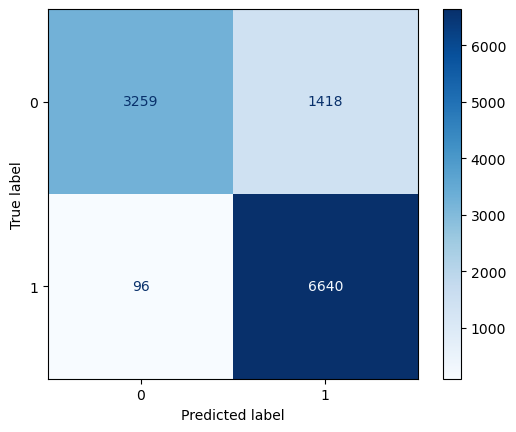

In [33]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
importances = gb_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'word': feature_names, 'importance': importances})
top_words = feature_importance_df.sort_values(by="importance", ascending=False)
print("Top palabras con mayor peso para Gradient Classifier")
print(top_words.head(20)) 

Top palabras con mayor peso para Gradient Classifier
            word  importance
1689         per    0.099323
1320        equo    0.089745
694       person    0.082379
144         cita    0.073801
329      espanol    0.066317
627        niega    0.058186
304   emergencia    0.047357
122       carcel    0.042788
857      segunda    0.042504
1288      eajpnv    0.035879
1711      podemo    0.033982
1101         bng    0.033187
557         mart    0.025648
716     polemica    0.023121
1116     canaria    0.020451
498        jueza    0.016517
415       gracia    0.016212
747     presunto    0.013273
1845     sanchez    0.012025
305      emerito    0.010518


## Tercer Modelo: K-Neighbors Classifier

Al igual que para los anteriores 2 modelos, los datos ya están preparados y listos para ser utilizados para entrenar este modelo, así que no es necesario realizar ningún paso extra antes de entrenar el modelo:

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=15)
knn_classifier.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=15)

In [62]:
Y_pred = knn_classifier.predict(X_test)
print(f"Presición: {accuracy_score(Y_test, Y_pred):.2f}")

Presición: 0.74


In [63]:
print("\nReporte para KNeighborsClassifier:")
print(classification_report(Y_test, Y_pred))


Reporte para KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.73      0.58      0.64      4677
           1       0.74      0.85      0.79      6736

    accuracy                           0.74     11413
   macro avg       0.73      0.71      0.72     11413
weighted avg       0.74      0.74      0.73     11413



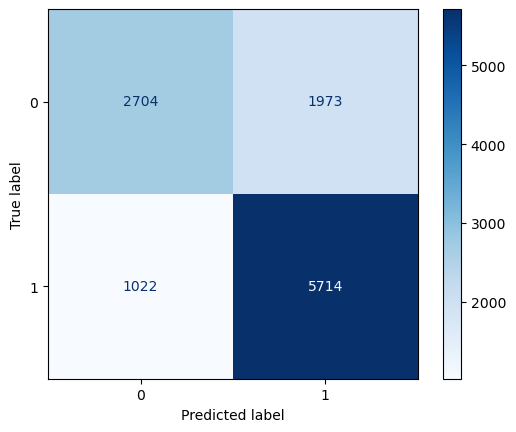

In [64]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dada la naturaleza de clasificación dada la cercanía de vecinos, no se puede analizar las palabras con mayor peso para el modelo de K-Neighbors

## Modelo 4: Regresión Logística

Again no se necesitan preparar los datos más de lo que ya están, cowabunga

In [26]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(random_state=16)
lr_classifier.fit(X_train, Y_train)

LogisticRegression(random_state=16)

In [27]:
Y_pred = lr_classifier.predict(X_test)
print(f"Presición: {accuracy_score(Y_test, Y_pred):.2f}")

Presición: 0.89


In [28]:
print("\nReporte para Logistic Regression Classifier:")
print(classification_report(Y_test, Y_pred))


Reporte para Logistic Regression Classifier:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4677
           1       0.87      0.94      0.91      6736

    accuracy                           0.89     11413
   macro avg       0.89      0.87      0.88     11413
weighted avg       0.89      0.89      0.88     11413



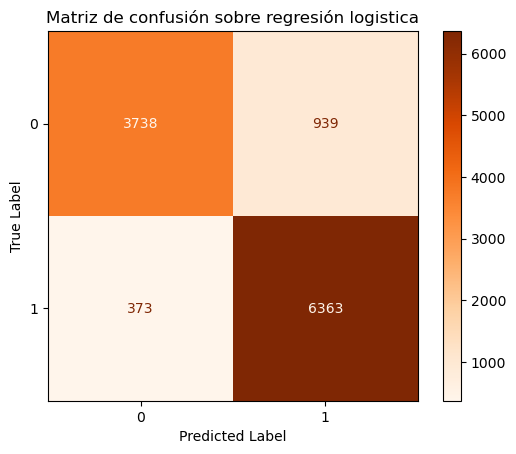

In [29]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_classifier.classes_)
disp.plot(cmap="Oranges")
plt.title("Matriz de confusión sobre regresión logistica")
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 
plt.show()


In [42]:
coefficients = lr_classifier.coef_[0]  
feature_names = np.array(tfidf.get_feature_names_out().tolist() * 2)  
coef_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})
coef_df = coef_df.sort_values(by="coefficient", ascending=True)
print("Top 20 words pushing predictions toward class 0:")
print(coef_df.head(20))

Top 20 words pushing predictions toward class 0:
            word  coefficient
1320        equo   -12.150459
329      espanol   -10.558925
304   emergencia   -10.085740
1288      eajpnv    -9.328464
1101         bng    -9.108498
122       carcel    -8.611664
144         cita    -7.369015
1689         per    -7.054499
627        niega    -6.953552
747     presunto    -6.695221
694       person    -6.692198
410      gestion    -6.482908
1116     canaria    -6.130106
1620     narbona    -5.648664
123        cargo    -5.381715
228        debat    -5.256471
1227       david    -4.915937
969        vasco    -4.784194
305      emerito    -4.702910
557         mart    -4.651472
